<a href="https://colab.research.google.com/github/marcus-v-rodrigues/ml-project/blob/main/Trabalho_Pr%C3%A1tico_1_%E2%80%93_Tarefas_Preditivas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Marcus Vinícius Santos Rodrigues - 11218862

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score, cross_val_predict, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import RandomOverSampler
from sklearn.decomposition import PCA
import seaborn as sns

In [ ]:
# Lendo os dados de espectros e metadados
spectra = pd.read_csv('pure_spectra_matrix.csv', header=None, sep=';')
metadata = pd.read_csv('pure_spectra_metadata.csv', sep=';')

In [ ]:
# Rebalanceamento dos dados
ros = RandomOverSampler(random_state=42)
X, y = ros.fit_resample(spectra, metadata['Species'])

In [ ]:
# Normalização dos dados antes da PCA
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [ ]:
# Aplicar PCA para reduzir a dimensionalidade
pca = PCA(n_components=0.95)  # Manter 95% da variância
X = pca.fit_transform(X)

In [ ]:
# Informações de saída
print(f'Dimensões originais: {spectra.shape[1]}, Dimensões após PCA: {X.shape[1]}')
print(f'Distribuição de classes após rebalanceamento:\n{pd.Series(y).value_counts()}')

Dimensões originais: 1300, Dimensões após PCA: 248
Distribuição de classes após rebalanceamento:
Species
RTO.TQH    60
BUT.YZE    60
NYV.VCE    60
BUT.TRH    60
AUG.AEX    60
EMD.WXC    60
QBG.CRP    60
AUG.HSS    60
RTO.JFR    60
JNH.ZIJ    60
VVJ.KWJ    60
NYV.XSY    60
QWP.LRO    60
EMD.FZO    60
QWP.DRH    60
BUT.BIK    60
BUT.DNW    60
JNH.FLH    60
VVJ.KSF    60
QBG.KGI    60
Name: count, dtype: int64


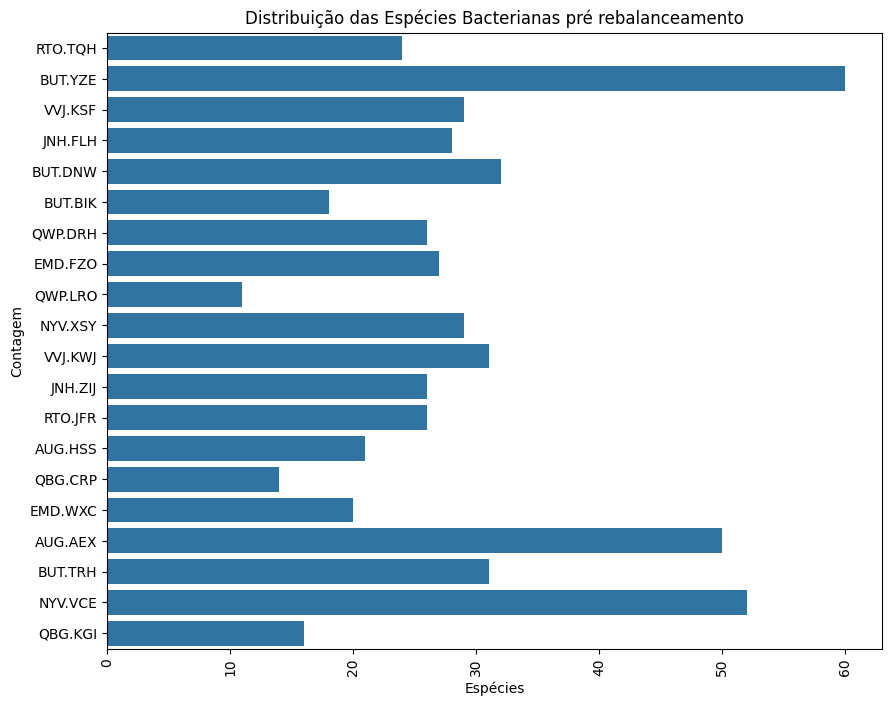

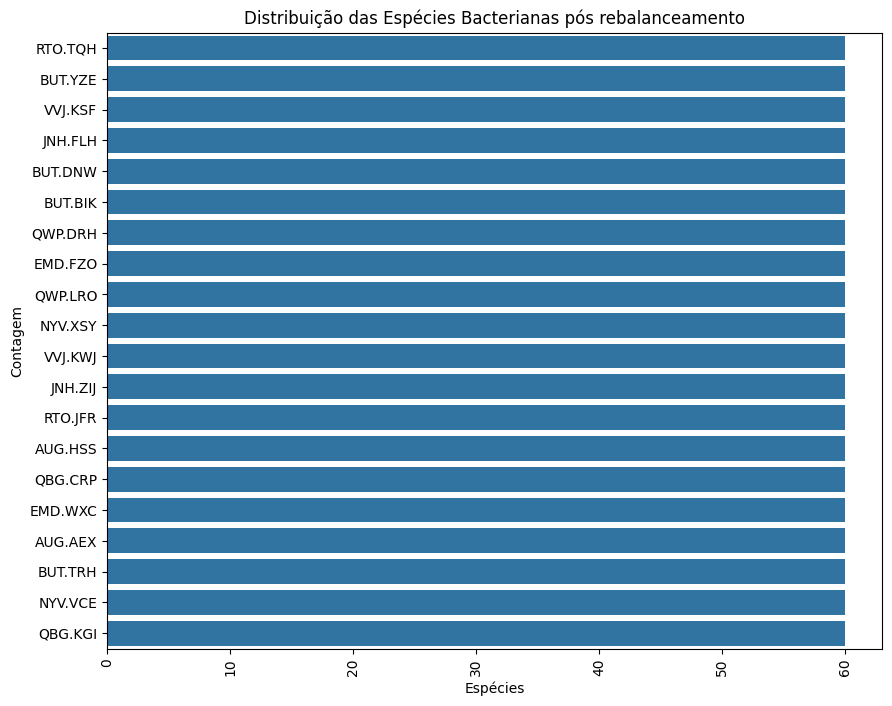

In [ ]:
# Visualização da distribuição das classes
plt.figure(figsize=(10, 8))
sns.countplot(y=metadata['Species'])
plt.title('Distribuição das Espécies Bacterianas pré rebalanceamento')
plt.xlabel('Espécies')
plt.ylabel('Contagem')
plt.xticks(rotation=90)
plt.show()

plt.figure(figsize=(10, 8))
sns.countplot(y=y)
plt.title('Distribuição das Espécies Bacterianas pós rebalanceamento')
plt.xlabel('Espécies')
plt.ylabel('Contagem')
plt.xticks(rotation=90)
plt.show()

In [ ]:
# Normalização dos dados para melhoria do desempenho do modelo
pipeline = make_pipeline(StandardScaler(), RandomForestClassifier(random_state=42))

In [ ]:
# Definição de cross-validation
cv = StratifiedKFold(n_splits=10)

In [ ]:
# Avaliação do modelo com cross-validation
scores = cross_val_score(pipeline, X, y, cv=cv, scoring='accuracy')
print("Acurácia média com 10-fold CV:", np.mean(scores))
print("Desvio padrão da acurácia:", np.std(scores))

Acurácia média com 10-fold CV: 0.9541666666666668
Desvio padrão da acurácia: 0.023935677693908464


In [ ]:
# Configuração detalhada do modelo final e geração do relatório de classificação
predicted = cross_val_predict(pipeline, X, y, cv=cv)
report = classification_report(y, predicted)
print("Relatório de classificação:\n", report)

Relatório de classificação:
               precision    recall  f1-score   support

     AUG.AEX       1.00      0.97      0.98        60
     AUG.HSS       0.97      1.00      0.98        60
     BUT.BIK       0.97      1.00      0.98        60
     BUT.DNW       0.81      0.93      0.87        60
     BUT.TRH       0.89      0.93      0.91        60
     BUT.YZE       0.83      0.58      0.69        60
     EMD.FZO       0.97      1.00      0.98        60
     EMD.WXC       1.00      0.97      0.98        60
     JNH.FLH       0.95      0.97      0.96        60
     JNH.ZIJ       0.98      0.98      0.98        60
     NYV.VCE       0.93      0.90      0.92        60
     NYV.XSY       0.92      0.97      0.94        60
     QBG.CRP       1.00      1.00      1.00        60
     QBG.KGI       0.97      1.00      0.98        60
     QWP.DRH       0.98      0.95      0.97        60
     QWP.LRO       0.97      1.00      0.98        60
     RTO.JFR       0.98      1.00      0.99        6

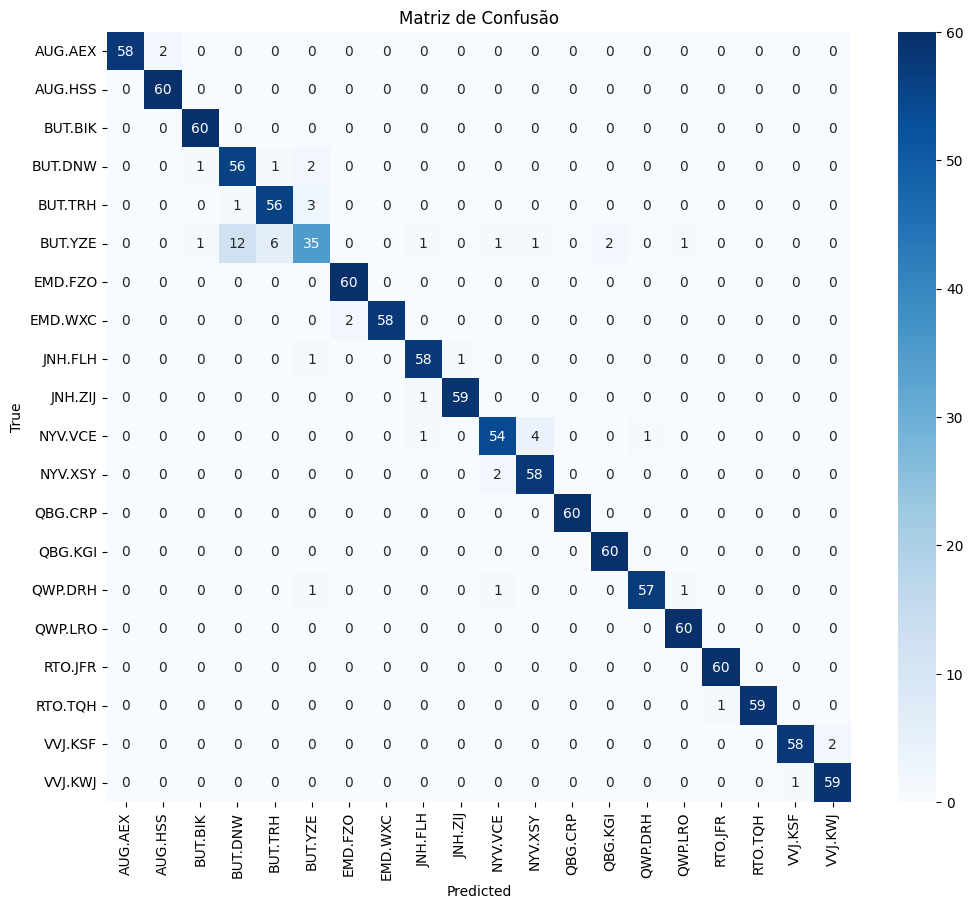

In [ ]:
# Matriz de confusão
cm = confusion_matrix(y, predicted)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.title('Matriz de Confusão')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()